In [1]:
import jax
import jax.numpy as np
import numpy.random as npr
import jax.random as jrnd

import jax.scipy.linalg as spla
import matplotlib.pyplot as plt
import tqdm
from jax.config import config
config.update("jax_enable_x64", True)

from scipy.stats import norm
from scipy.stats import gaussian_kde

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Overview

Original convex envelopes code. Next steps:
1. Implement IG objective with slice sampling in jax

Other:
* Scipy convex hulls?
* Hyperparameter opt (e.g. marginal likelihood)
* Run on a synthetic data set

## Exploratory

In [13]:
def kernel(x1, x2, ls):
    x1 = np.atleast_2d(x1)
    x2 = np.atleast_2d(x2)
    return np.exp(-0.5*(x1.T-x2)**2/ls**2)

d_kernel = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x1, x2, ls: kernel(x1, x2, ls)[0,0], argnums=0), argnums=1), in_axes=(0,0,None)))

In [3]:
#npr.seed(2)

npr.seed(22)
# Number of knots to compute
knot_N = 200
# Length scale
ls = 0.1
# X points
knot_x = np.linspace(0, 1, knot_N)
# Kernel matrix
knot_K = kernel(knot_x, knot_x, ls) + 1e-8 * np.eye(knot_N)
# Cholesky decomposition
knot_cK = spla.cholesky(knot_K)

@jax.jit
def f(x, knot_y):
    cross = kernel(x, knot_x, ls)
    return cross @ spla.cho_solve((knot_cK,  False), knot_y)
D1f = jax.jit(jax.vmap(jax.grad(lambda x, y: f(x,y)[0]), in_axes=(0, None)))
D2f = jax.jit(jax.vmap(jax.grad(jax.grad(lambda x, y: f(x,y)[0])), in_axes=(0, None)))

knot_z = npr.randn(knot_N)
knot_y = knot_cK.T @ knot_z

In [4]:
# Legendre-Fenchel Transform

# What range do we need to think about?
# Let's do 3 sigma.
deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, ls)))
s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

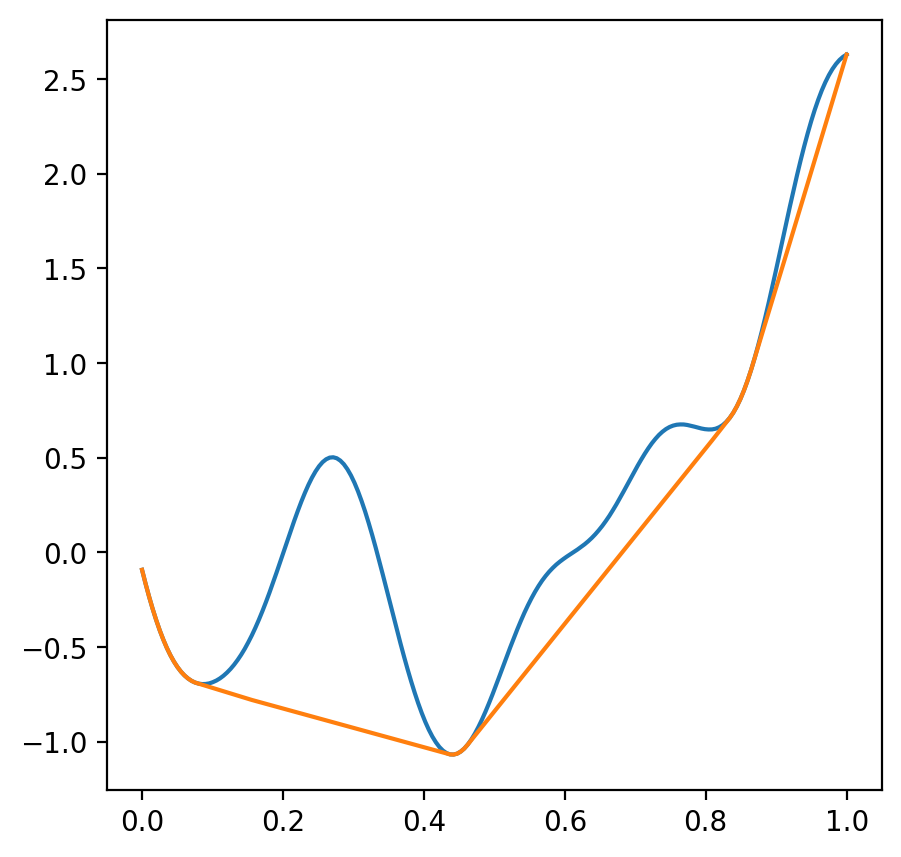

In [5]:
# Compute the convex envelope given x and y values
def convelope(knot_x, knot_y):
    knot_y = np.atleast_2d(knot_y) # samples x num_primal
    sx = s[:,np.newaxis] * knot_x[np.newaxis,:] # num_dual x num_primal
    # compute the conjugate
    lft1 = np.max(sx[np.newaxis,:,:] - knot_y[:,np.newaxis,:],  axis=2) # samples x num_dual
    # compute the biconjugate
    lft2 = np.max(sx[np.newaxis,:,:] - lft1[:,:,np.newaxis],  axis=1) # samples x num_primal
    return lft2

# Plot the convex envelope of a function
plt.figure(figsize=(5,5))
plt.plot(knot_x,  knot_y, knot_x, convelope(knot_x, knot_y).T)

In [6]:
def make_preds(train_x, train_y, test_x):
    # Compute the training kernels.
    train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
    cross_K = kernel(train_x, test_x, ls)
    kappa_K = kernel(test_x, test_x, ls)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(knot_N)

    return pred_mean, pred_cov

In [7]:
num_pred = 500

npr.seed(5)
# Form the true function of interest at knot_N number of points
true_y = knot_cK.T @ npr.randn(knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0], knot_x[-1]])
train_y = np.array([true_y[0], true_y[-1]])

In [8]:
pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

pred_cK = spla.cholesky(pred_cov)
pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]

# compute envelopes based on samples from the predictive distribution
envelopes = convelope(knot_x, pred_Y.T)
# compute envelope based on true function
true_envelope = convelope(knot_x, true_y)

# Computes a probability of tightness based on how far the predictive sample and its envelope are
p_tight = np.clip(np.mean(np.abs(envelopes - pred_Y.T) < 1e-3, axis=0), 1e-6, 1-1e-6)

In [9]:
pred_cov

DeviceArray([[1.99999900e-06, 9.98737204e-07, 9.94961359e-07, ...,
              3.32371838e-28, 1.25763276e-28, 1.92851603e-34],
             [9.98737204e-07, 2.52400063e-03, 5.03228302e-03, ...,
              2.12362106e-22, 8.06779819e-23, 1.25763276e-28],
             [9.94961359e-07, 5.03228302e-03, 1.00519037e-02, ...,
              5.58438897e-22, 2.12362106e-22, 3.32371838e-28],
             ...,
             [3.32371838e-28, 2.12362106e-22, 5.58438897e-22, ...,
              1.00519037e-02, 5.03228302e-03, 9.94961359e-07],
             [1.25763276e-28, 8.06779819e-23, 2.12362106e-22, ...,
              5.03228302e-03, 2.52400063e-03, 9.98737204e-07],
             [1.92875113e-34, 1.25763276e-28, 3.32371838e-28, ...,
              9.94961359e-07, 9.98737204e-07, 1.99999900e-06]],            dtype=float64)

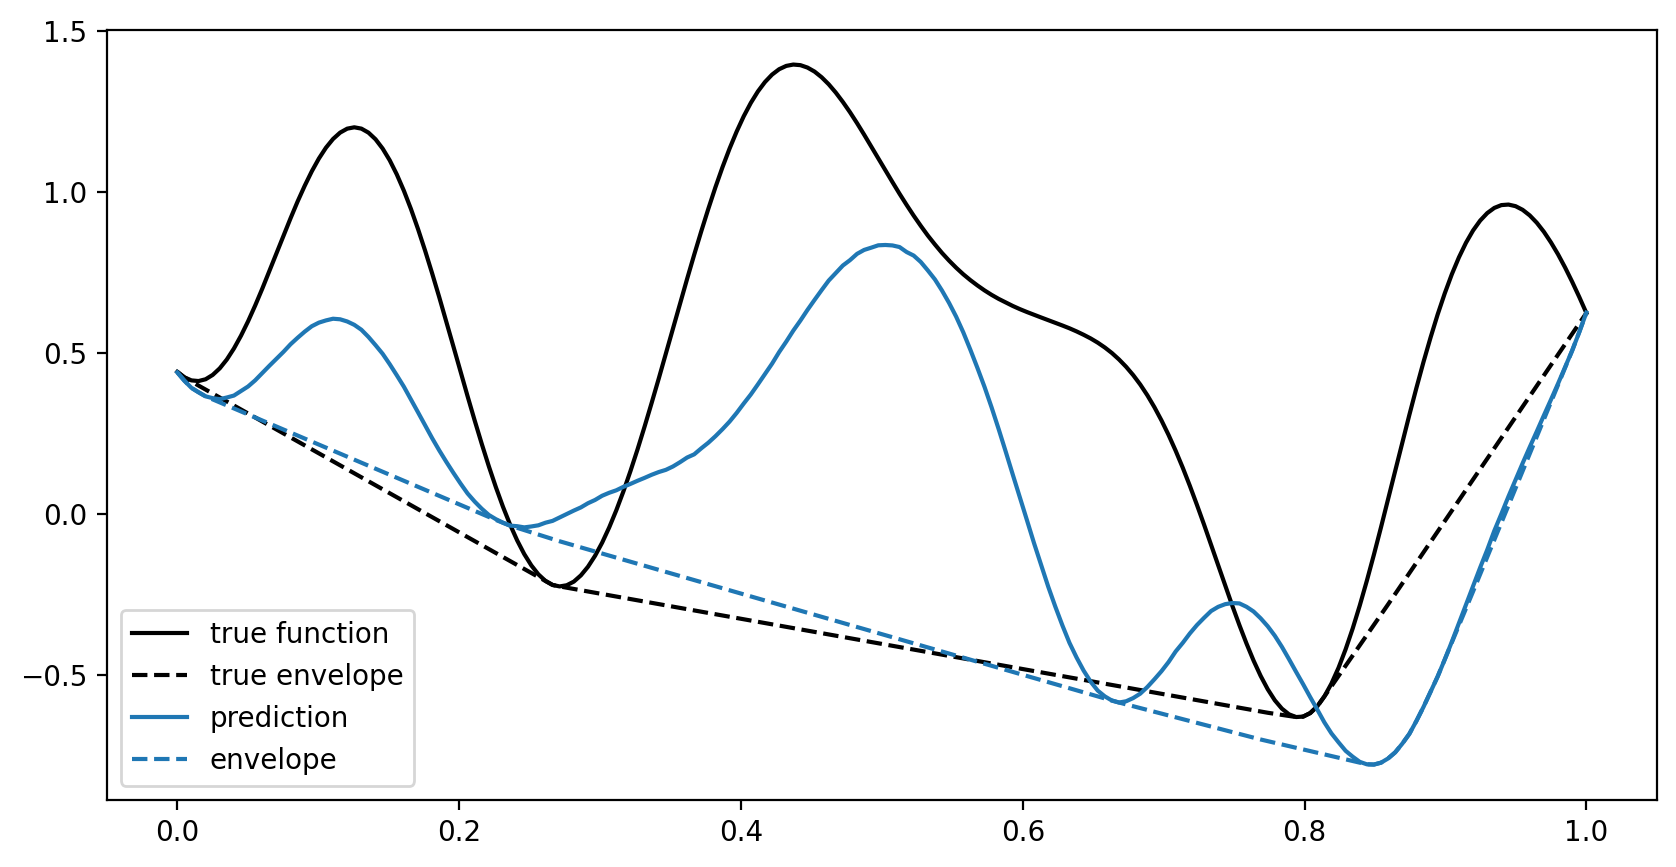

In [10]:
plt.figure(figsize=(10,5))

# Plot the true function and its envelope 
plt.plot(knot_x, true_y, c="k", label="true function")
plt.plot(knot_x, true_envelope[1], label="true envelope", c="k", ls="--")
# Plot a prediction and its envelope
plt.plot(knot_x, pred_Y.T[1,:], c="tab:blue", label="prediction")
plt.plot(knot_x, envelopes[1], label="envelope", c="tab:blue", ls="--")
plt.legend()

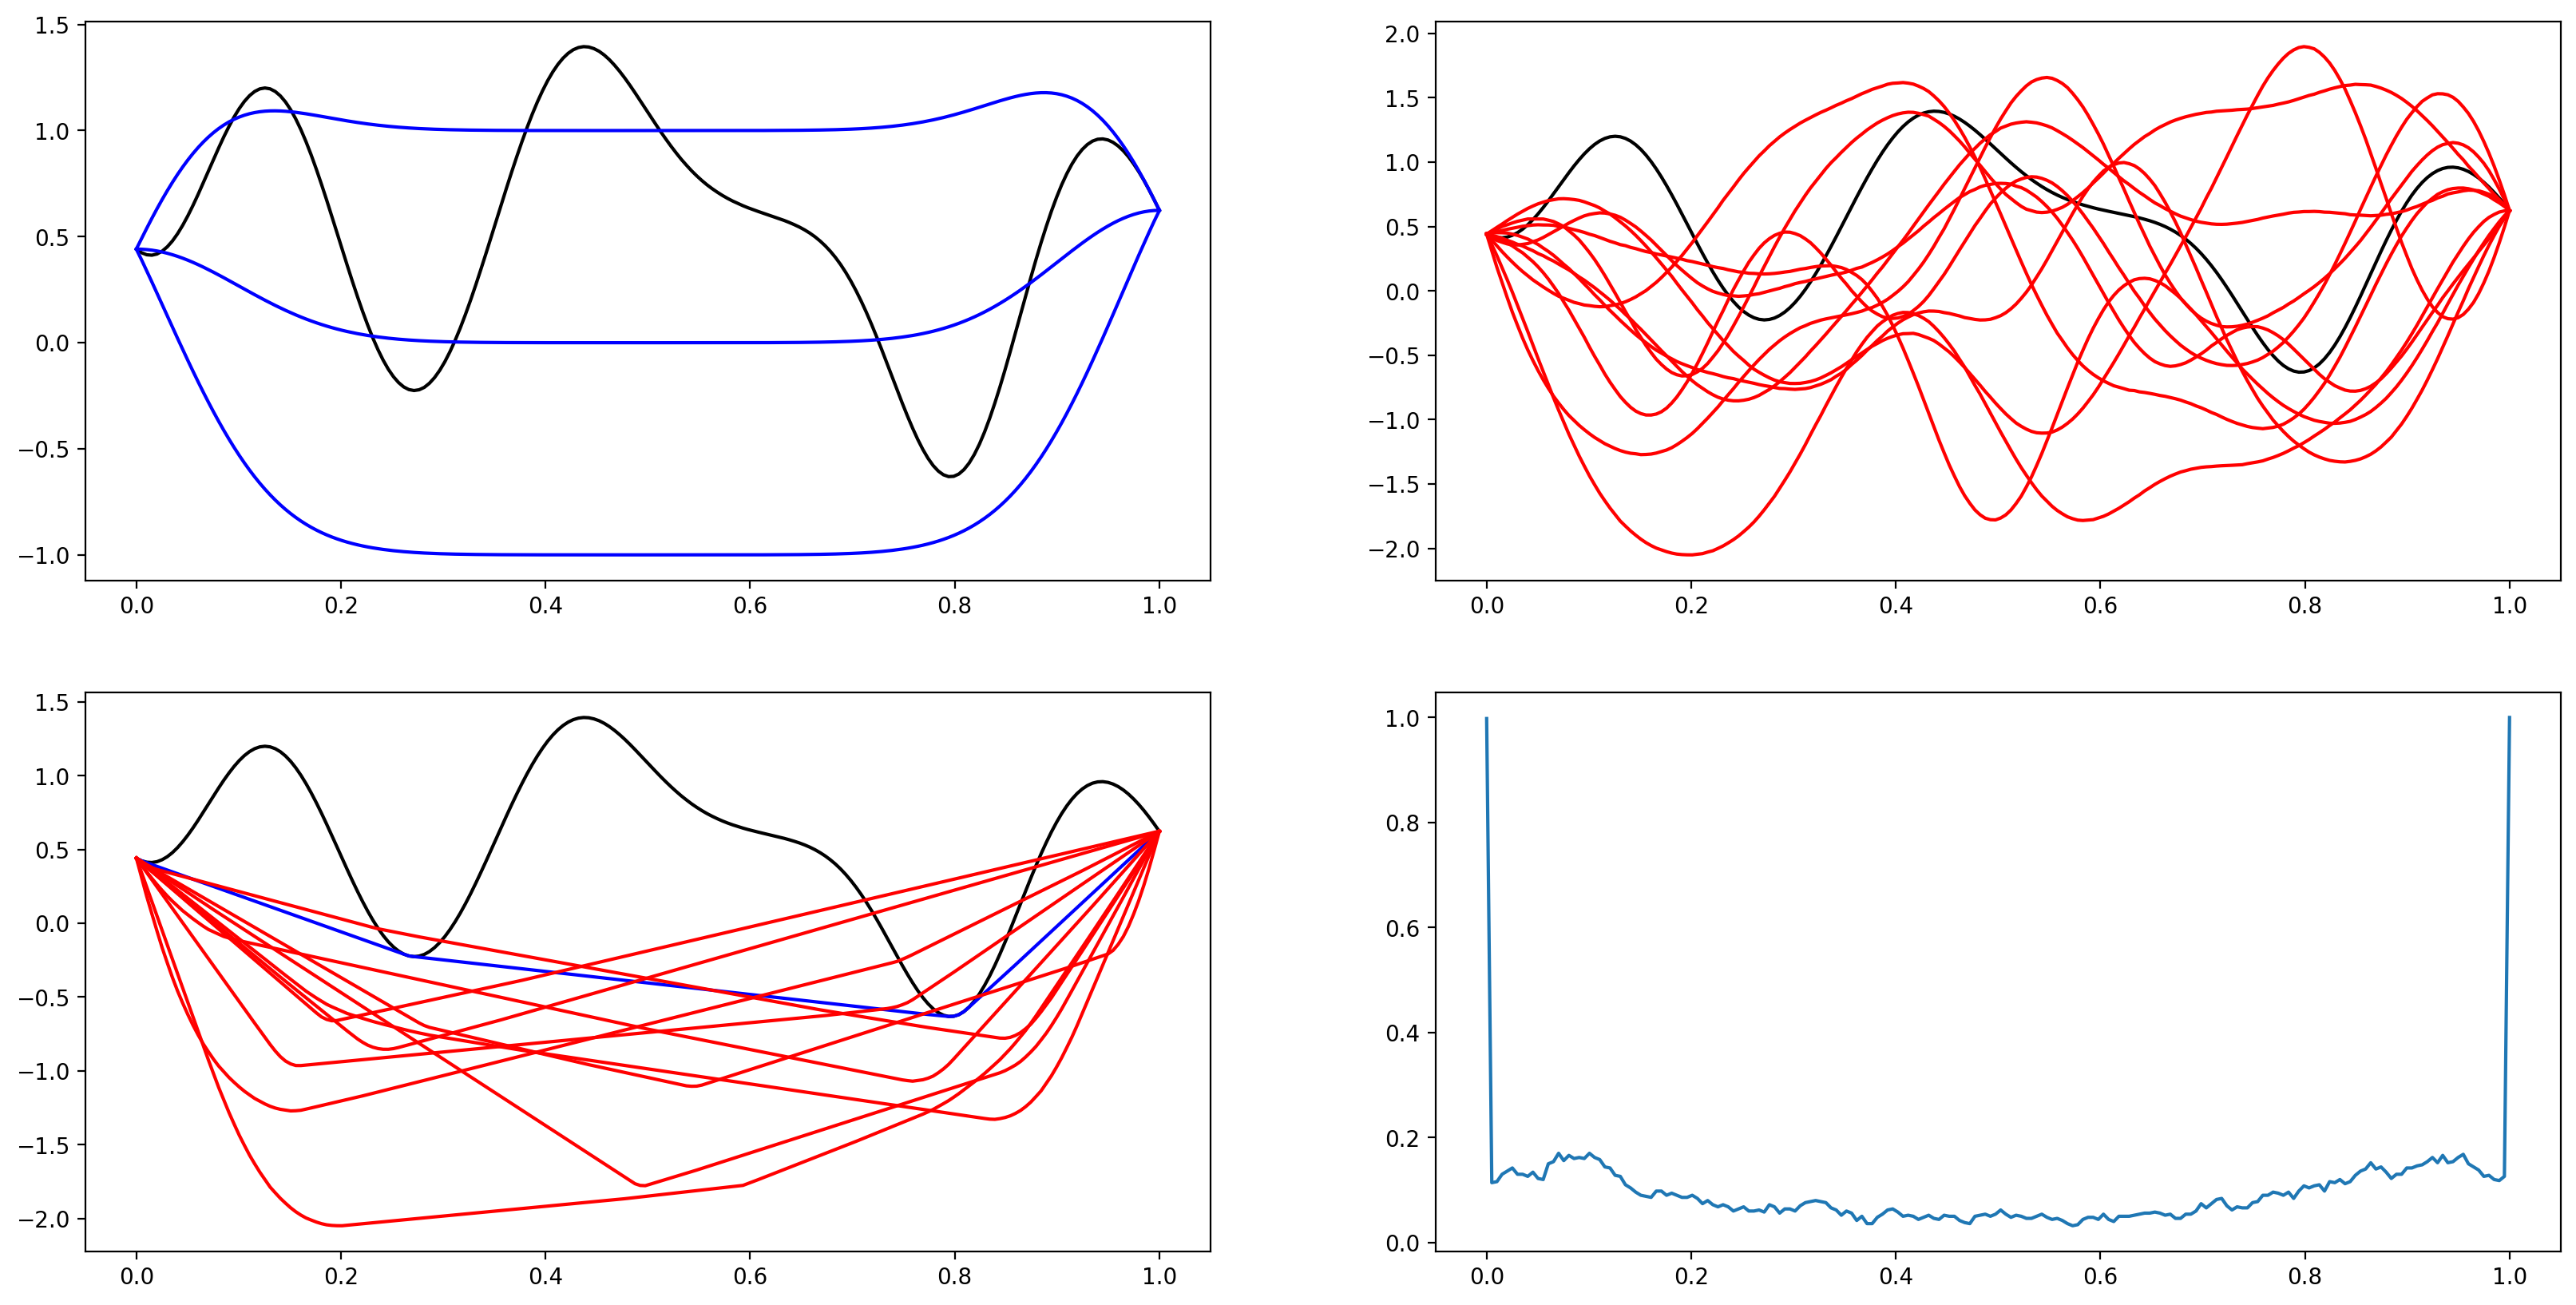

In [11]:
plt.figure(figsize=(20,10))

# Plot the predictive mean and variance
plt.subplot(2,2,1)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_mean, 'b-', knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-', knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')

# Draw functions from the posterior
plt.subplot(2,2,2)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')

# Compute the hulls of those samples
plt.subplot(2,2,3)
plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')

# Plot the probability of tightness
plt.subplot(2,2,4)
plt.plot(knot_x, p_tight)
plt.show()

In [12]:
num_y_bins = 10

import scipy.stats as sps
u_borders = np.linspace(0, 1, num_y_bins+1)

envelopes = convelope(knot_x, pred_Y.T)
tights = np.abs(envelopes - pred_Y.T) < 1e-3
p_tight = np.clip(np.mean(tights, axis=0), 1e-6, 1-1e-6)
# plt.plot(knot_x, p_tight)

In [14]:
# Marginal bits
cur_entropy = -np.sum( p_tight*np.log2(p_tight) + (1-p_tight)*np.log2(1-p_tight))

# Do this with slow loops to start out. ### TODO: modify this to compute IG with posterior
entropy_change = []
for nn in tqdm.tqdm(range(knot_N)):
    mean = pred_mean[nn]
    var  = pred_cov[nn,nn]
    borders = sps.norm.ppf(u_borders, loc=mean, scale=np.sqrt(var))[:,np.newaxis]
    Y = pred_Y[nn,:]
    Ybin = np.logical_and(borders[:-1] <= Y, Y < borders[1:]).T

    mean_entropy = 0
    for ii in range(num_y_bins):
        cond_p_tight = np.clip(np.mean(tights[Ybin[:,ii],:], axis=0), 1e-6, 1-1e-6)
        cond_entropy = -np.sum( cond_p_tight*np.log2(cond_p_tight) + (1-cond_p_tight)*np.log2(1-cond_p_tight))
        mean_entropy += cond_entropy/num_y_bins
    entropy_change.append(cur_entropy - mean_entropy)
entropy_change = np.array(entropy_change)

best_idx = np.argmax(entropy_change)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:10<00:00, 20.00it/s]


In [15]:
best_idx

DeviceArray(182, dtype=int64)

Text(0.5, 1.0, 'True energy and current mean/std')

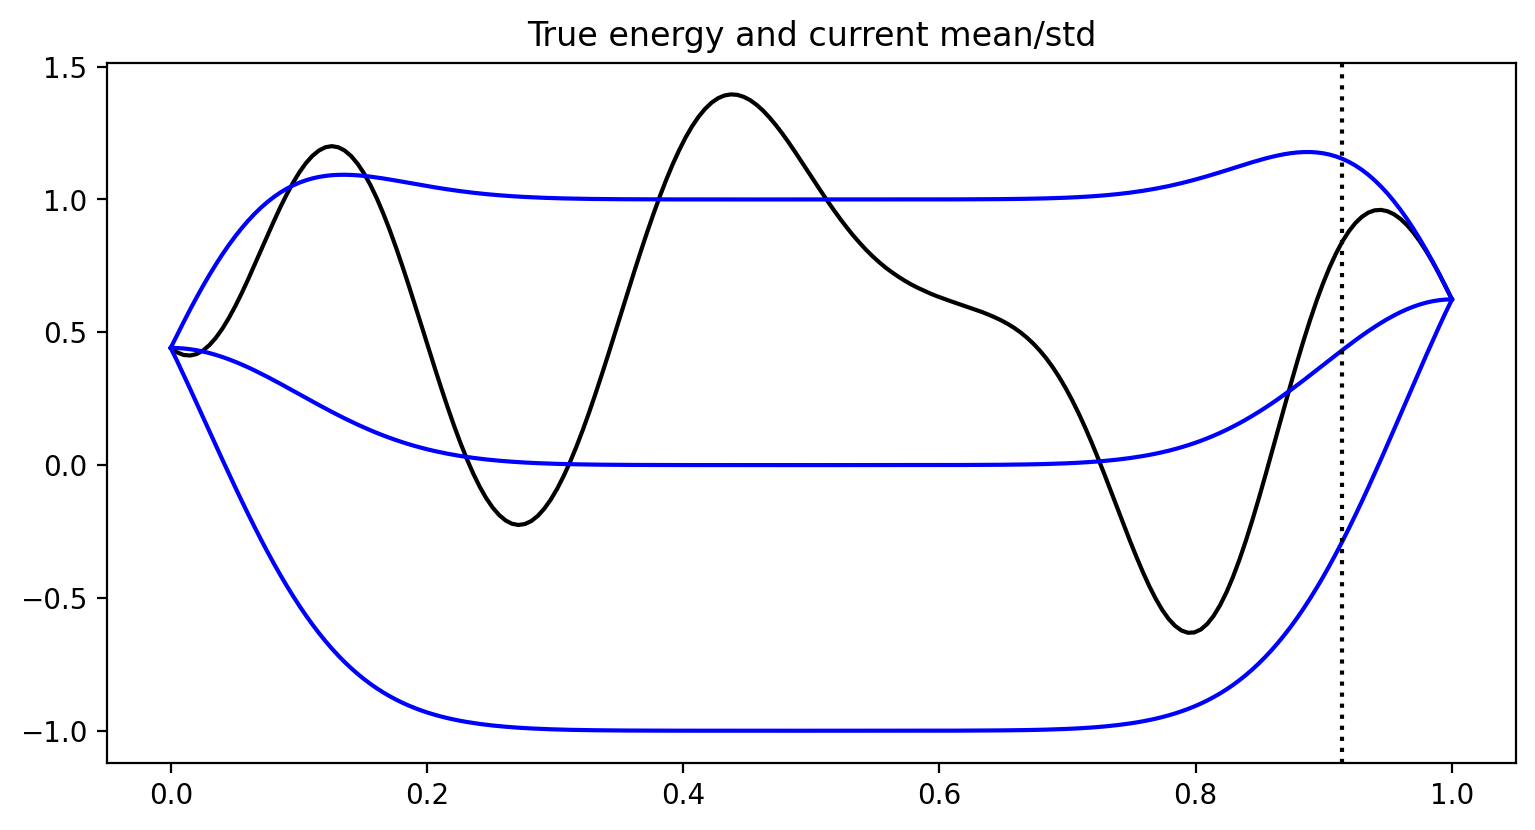

In [16]:
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(knot_x,  true_y, 'k-')
# when did we update the predictive eman?
plt.plot(knot_x, pred_mean, 'b-')
plt.plot(knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-')
plt.plot(knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')
plt.axvline(knot_x[best_idx], ls="dotted", c="k")
plt.title('True energy and current mean/std')

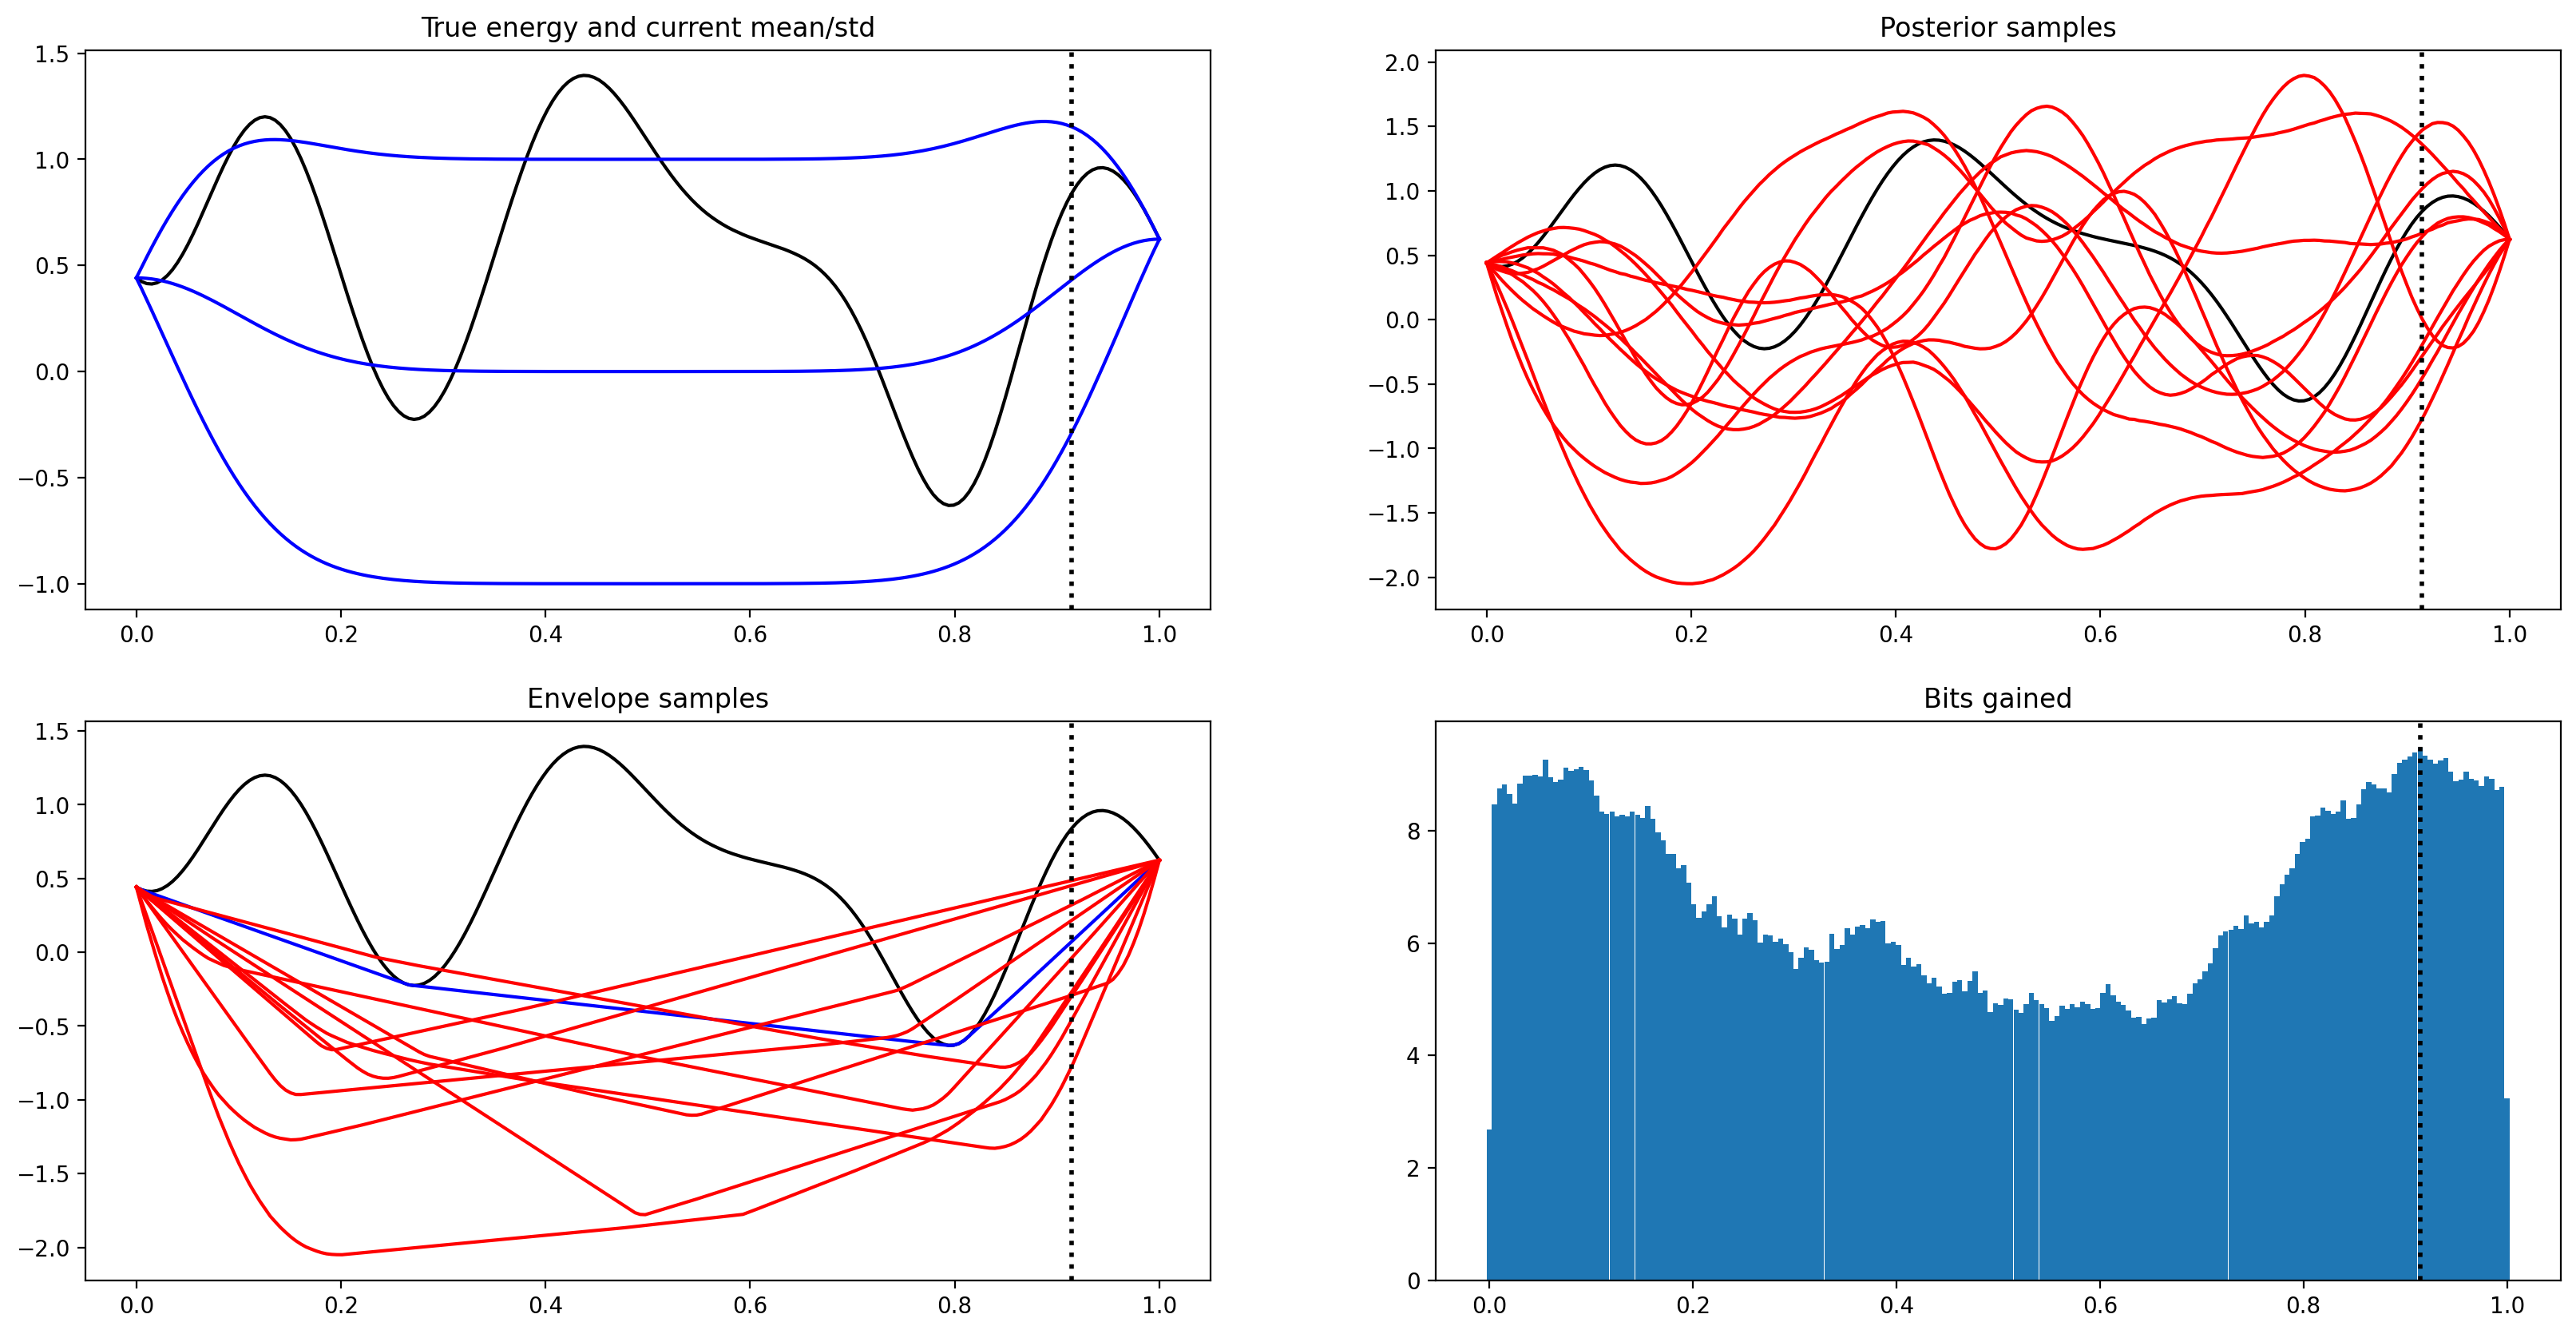

In [17]:
# Plot results
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_mean, 'b-', knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-', knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('True energy and current mean/std')

plt.subplot(2,2,2)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('Posterior samples')

plt.subplot(2,2,3)
plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('Envelope samples')

plt.subplot(2,2,4)
plt.bar(knot_x,  entropy_change, width=(1./knot_N))
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('Bits gained')

plt.show()

In [18]:
# Make prediction at the best_idx point
train_x = np.append(train_x, knot_x[best_idx])
train_y = np.append(train_y, true_y[best_idx])

pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

pred_cK = spla.cholesky(pred_cov)
pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]

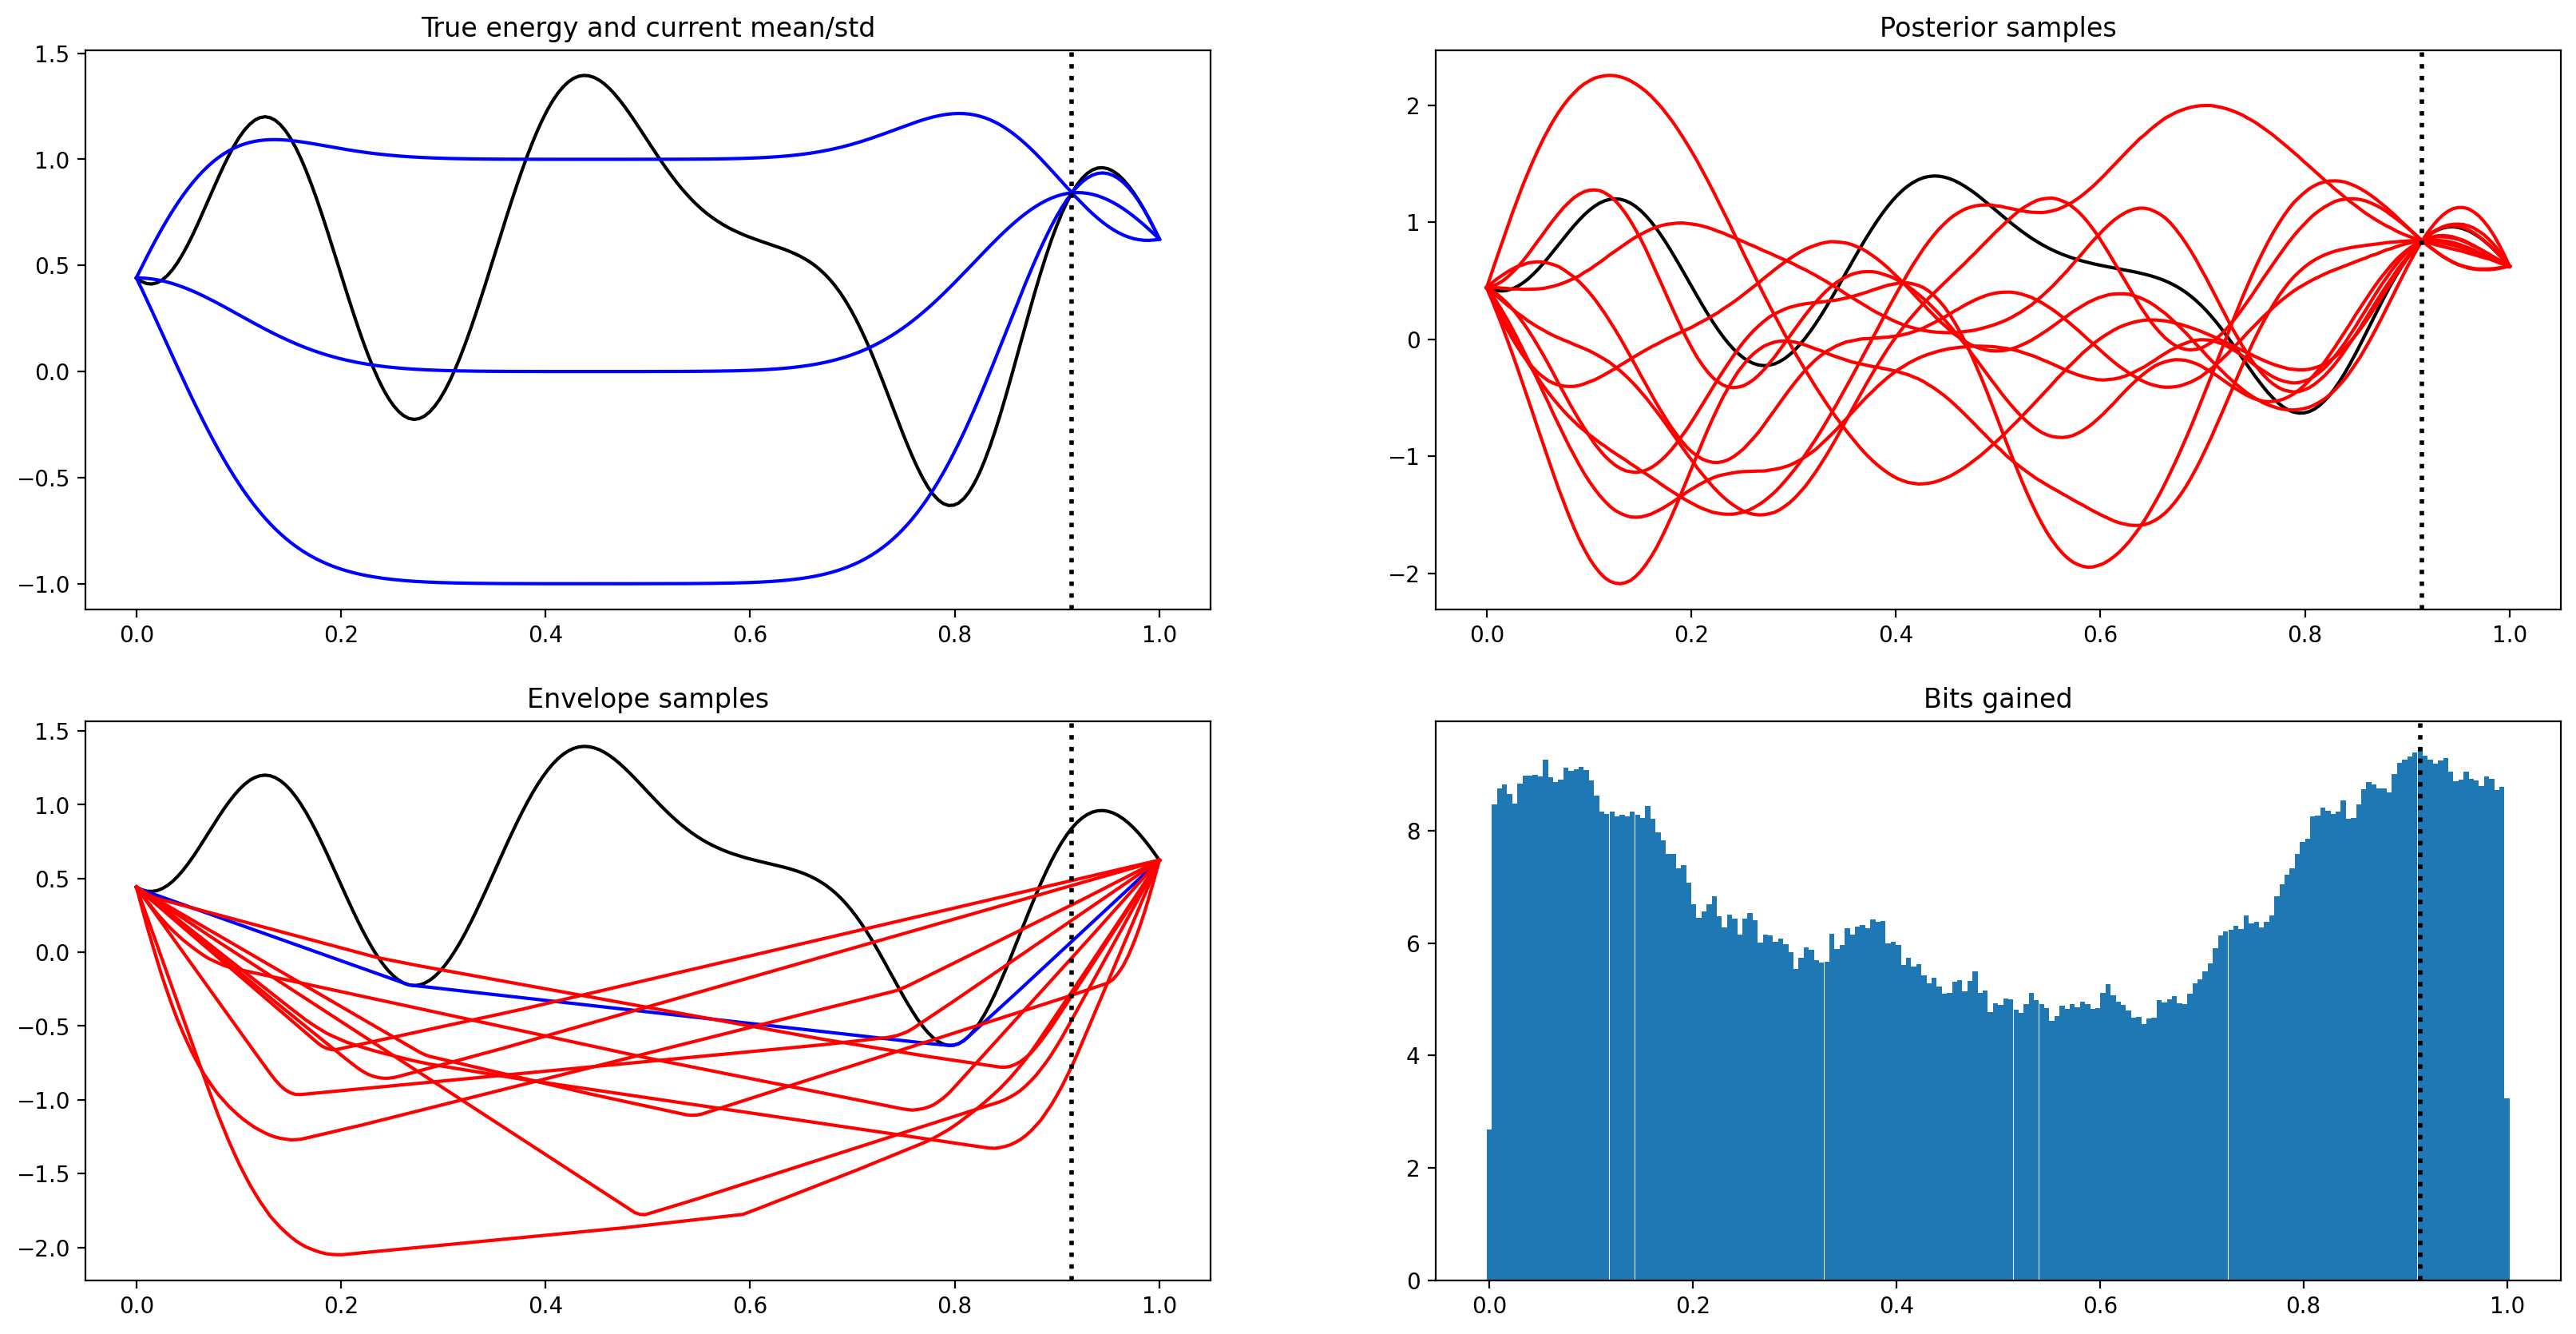

In [19]:
# Plot results
plt.figure(figsize=(20,10))
plt.subplot(2,2,1)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_mean, 'b-', knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-', knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('True energy and current mean/std')

plt.subplot(2,2,2)
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('Posterior samples')

plt.subplot(2,2,3)
plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('Envelope samples')

plt.subplot(2,2,4)
plt.bar(knot_x,  entropy_change, width=(1./knot_N))
plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('Bits gained')

plt.show()

# Turn things into a function

In [20]:
def compute_mean_entropy(knot_x, pred_Y, pred_mean, pred_cov):
    mean_entropy = 0
    num_y_bins = 10
    
    u_borders = np.linspace(0, 1, num_y_bins+1)

    envelopes = convelope(knot_x, pred_Y.T)
    tights = np.abs(envelopes - pred_Y.T) < 1e-3
    p_tight = np.clip(np.mean(tights, axis=0), 1e-6, 1-1e-6)
    
    cur_entropy = -np.sum( p_tight*np.log2(p_tight) + (1-p_tight)*np.log2(1-p_tight))

    # Do this with slow loops to start out. ### TODO: modify this to compute IG with posterior
    entropy_change = []
    for nn in tqdm.tqdm(range(knot_N)):
        mean = pred_mean[nn]
        var  = pred_cov[nn,nn]
        borders = sps.norm.ppf(u_borders, loc=mean, scale=np.sqrt(var))[:,np.newaxis]
        Y = pred_Y[nn,:]
        Ybin = np.logical_and(borders[:-1] <= Y, Y < borders[1:]).T

        mean_entropy = 0
        for ii in range(num_y_bins):
            cond_p_tight = np.clip(np.mean(tights[Ybin[:,ii],:], axis=0), 1e-6, 1-1e-6)
            cond_entropy = -np.sum( cond_p_tight*np.log2(cond_p_tight) + (1-cond_p_tight)*np.log2(1-cond_p_tight))
            mean_entropy += cond_entropy/num_y_bins
        entropy_change.append(cur_entropy - mean_entropy)
    entropy_change = np.array(entropy_change)
    return entropy_change

In [21]:
def plot_results(knot_x, true_y, true_envelope, envelopes, entropy_change, knot_N, best_idx):
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(knot_x,  true_y, 'k-', knot_x, pred_mean, 'b-', knot_x, pred_mean + np.sqrt(np.diag(pred_cov)), 'b-', knot_x, pred_mean - np.sqrt(np.diag(pred_cov)), 'b-')
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
    plt.title('True energy and current mean/std')
    
    plt.subplot(1,2,2)
    plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
    plt.title('Posterior samples')

    # Plot results
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=3)
    plt.title('Envelope samples')

    plt.subplot(1,2,2)
    plt.bar(knot_x,  entropy_change, width=(1./knot_N))
    plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=3)
    plt.title('Bits gained')

    plt.show()

## Next steps

Replace the entropy computation above with IG slice sampling.

## Exploratory: estimating the entropy with slice sampling and KDE

TODO: integrate this into the above code and jit things

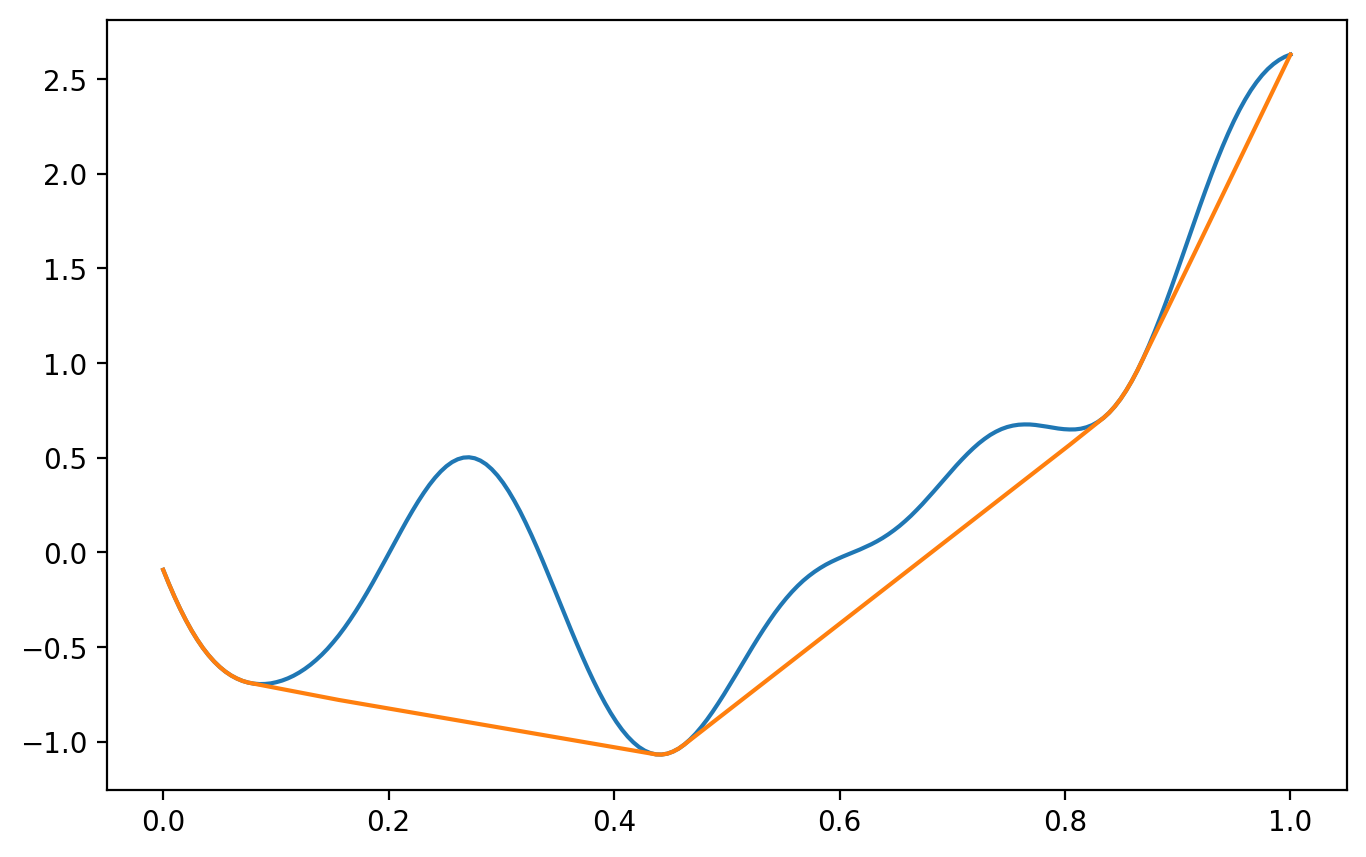

In [22]:
# Legendre-Fenchel Transform

# What range do we need to think about?
# Let's do 3 sigma.
deriv_marg_var = np.max(np.diag(d_kernel(knot_x, knot_x, ls)))
s = np.linspace(-3*np.sqrt(deriv_marg_var), 3*np.sqrt(deriv_marg_var), 500)

hull = convelope(knot_x, knot_y).ravel()

plt.figure(figsize=(8,5))
plt.plot(knot_x,  knot_y, knot_x, hull)

In [23]:
tight = knot_y - hull < 1e-3
def same_tight(y, tight):
    new_hull = convelope(knot_x, y).ravel()
    new_tight = y - new_hull < 1e-3
    return np.all(tight == new_tight)

def var2entropy(v):
    return 0.5*np.log(2*np.pi*v) + 0.5

In [24]:
# Rewrite this in jax.
def elliptical_slice(x0, log_lh_func, cK, num_steps):
    D = x0.shape[0]
    samples = []
    x = x0
    #for ii in tqdm.tqdm(range(num_steps)):
    for ii in range(num_steps):
        nu = cK.T @ npr.randn(D)
        u = npr.rand()
        log_y = log_lh_func(x) + np.log(u)
        theta = npr.rand() * 2 * np.pi
        upper = theta
        lower = theta - 2 * np.pi
        shrinks = 0
        while True:
            theta = npr.rand()*(upper-lower) + lower
            new_x = x * np.cos(theta) + nu * np.sin(theta)
            if log_lh_func(new_x) > log_y:
                x = new_x
                break
            else:
                shrinks = shrinks + 1
                if theta > 0:
                    upper = theta
                else:
                    lower = theta
            #if ii % 100 == 0:
            #    print(ii, shrinks, theta)
        samples.append(x)
    return np.array(samples)


def elliptical_slice_jax(x0, log_lh_func, chol, num_samples, rng_key):

    @jax.jit
    def ess_step_condfun(state):
        x, new_x, nu, thresh, lower, upper, rng_key = state
        llh = log_lh_func(new_x)
        return log_lh_func(new_x) < thresh

    @jax.jit
    def ess_step_bodyfun(state):
        x, new_x, nu, thresh, lower, upper, rng_key = state
        theta_rng, rng_key = jrnd.split(rng_key, 2)
        theta = jrnd.uniform(theta_rng, minval=lower, maxval=upper)
        new_x = x * np.cos(theta) + nu * np.sin(theta)
        lower, upper = jax.lax.cond(theta < 0, lambda : (theta, upper), lambda : (lower, theta))
        return x, new_x, nu, thresh, lower, upper, rng_key

    @jax.jit
    def ess_step(x, rng_key):
        nu_rng, u_rng, theta_rng, rng_key = jrnd.split(rng_key, 4)
        nu = chol.T @ jrnd.normal(nu_rng, shape=x.shape)
        u = jrnd.uniform(u_rng)
        thresh = log_lh_func(x) + np.log(u)
        theta = jrnd.uniform(theta_rng, minval=0, maxval=2* np.pi)
        upper = theta
        lower = theta - 2* np.pi
        new_x = x * np.cos(theta) + nu * np.sin(theta)
        _, new_x, _, _, _, _, _ = jax.lax.while_loop(
          ess_step_condfun,
          ess_step_bodyfun,
          (x, new_x, nu, thresh, lower, upper, rng_key)
        )
        return new_x

    @jax.jit
    def scanfunc(state, xs):
        x, rng_key = state
        step_key, rng_key = jrnd.split(rng_key, 2)
        x = ess_step(x, step_key)
        return (x, rng_key), x

    _, samples = jax.lax.scan(scanfunc, (x0, rng_key), None, num_samples)

    return samples

In [25]:
# slow ESS samples
samps = elliptical_slice(knot_y, lambda x: np.log(same_tight(x, tight)), knot_cK, 300)
#plt.figure(figsize=(10,10))

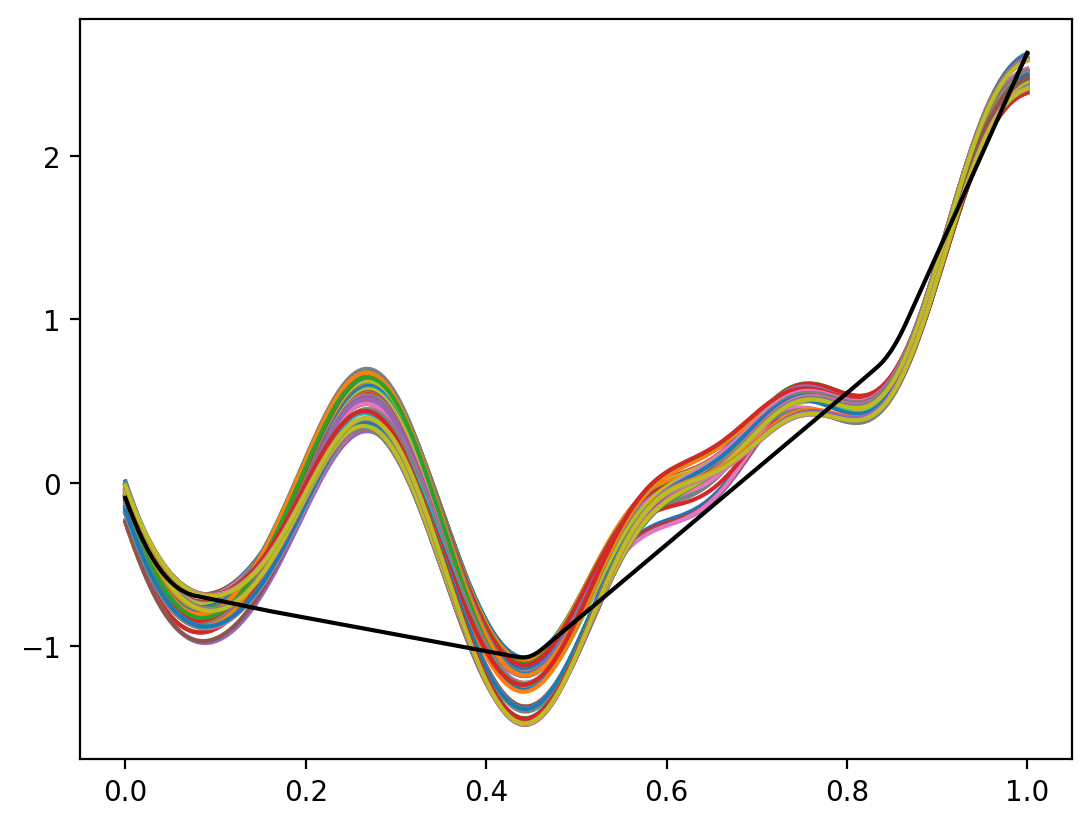

In [26]:
# These are sampling functions that are tight w.r.t. their own hull 
# at the same points as "tight" -- NOT saying they have the same hull as the original
plt.plot(knot_x, samps.T[:,-100:-1], knot_x, hull, 'k-')
plt.show()

In [190]:
# jax ESS 
rng_key = jrnd.PRNGKey(1)
%timeit elliptical_slice_jax(knot_y, lambda x: np.log(same_tight(x, tight)), knot_cK, 300, rng_key)

2.41 s ± 91.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


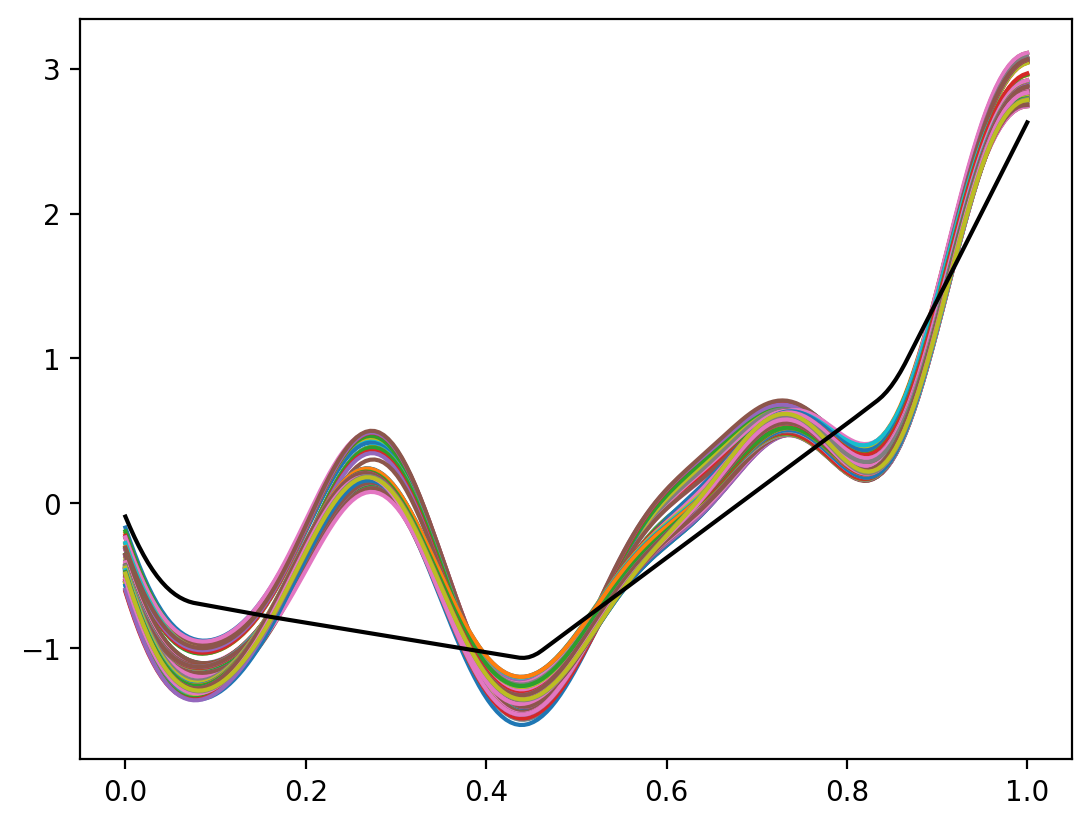

In [28]:
# These are sampling functions that are tight w.r.t. their own hull 
# at the same points as "tight" -- NOT saying they have the same hull as the original
plt.plot(knot_x, samps2.T[:,-100:-1], knot_x, hull, 'k-')
plt.show()

In [94]:
## TODO: jaxify
def make_pred_single(train_x, train_y, test_x):
    # Compute the training kernels.
    train_K = kernel(train_x, train_x, ls) + 1e-6*np.eye(train_x.shape[0])
    cross_K = kernel(train_x, test_x, ls)
    kappa_K = kernel(test_x, test_x, ls)

    # Predictive parameters.
    train_cK = spla.cholesky(train_K)
    cross_solve = spla.cho_solve((train_cK,  False), cross_K)
    pred_mean = train_y.T @ cross_solve
    pred_cov  = kappa_K - cross_K.T @ cross_solve + 1e-6*np.eye(1)

    return pred_mean.ravel()[0], pred_cov.ravel()[0]

In [30]:
#def compute_log_scond_pred_term(samp_f, putative_x, y_star):
#    """
#    knot_y is y^*
#    """
#    # compute a single term
#    test_mu, test_Sigma = make_pred_single(knot_x, samp_f, putative_x)
#    return norm.pdf(test_mu, test_Sigma, y_star)  

def sample_log_scond_pred_term(samp_f, putative_x):
    """
    knot_y is y^*
    """
    # compute a single term
    test_mu, test_Sigma = make_pred_single(knot_x, samp_f, putative_x)
    return npr.normal(test_mu, test_Sigma)

In [160]:
make_pred_single_wrap = lambda arg: make_pred_single(knot_x, arg, putative_x) ## TODO knot_x is global var here
makepred_vmap = jax.jit(jax.vmap(make_pred_single_wrap, in_axes=(0,)))
mus, sigmas = makepred_vmap(samps)

In [192]:
mus, sigmas = makepred_vmap(samps)
ystars = jrnd.multivariate_normal(rng_key, mus, np.eye(sigmas.shape[0])*sigmas)

In [193]:
ystars

DeviceArray([-0.29477512, -0.31156037, -0.29200087, -0.25976954,
             -0.25939305, -0.26904529, -0.25037602, -0.26403893,
             -0.25228273, -0.24310836, -0.26143613, -0.25643738,
             -0.2591767 , -0.26639178, -0.2616013 , -0.28181848,
             -0.20118879, -0.20513489, -0.21876966, -0.21872867,
             -0.21842847, -0.21907411, -0.21892439, -0.21866675,
             -0.21941311, -0.21987242, -0.22070216, -0.23959395,
             -0.24843654, -0.23968741, -0.23395527, -0.23683001,
             -0.20912429, -0.20829788, -0.26114397, -0.25470559,
             -0.24869373, -0.24930481, -0.25122144, -0.25141299,
             -0.26018903, -0.28246481, -0.26958845, -0.25829809,
             -0.25325595, -0.21887834, -0.22873193, -0.22371129,
             -0.2158395 , -0.21168059, -0.15942763, -0.16455305,
             -0.15804287, -0.14083785, -0.12943019, -0.09966993,
             -0.12091497, -0.11789115, -0.11489384, -0.12438341,
             -0.15056378,

In [97]:
norm.pdf(test_mu, test_Sigma, 0.1)  

0.0007642599109657152

In [123]:
npr.normal(np.zeros(4), np.eye(4))

array([[ 0.50046463,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.75791042,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  1.60891114,  0.        ],
       [ 0.        ,  0.        ,  0.        , -1.33006959]])

In [100]:
sample_log_scond_pred_term(samps[1], putative_x)

-0.3125194894250436

In [170]:
ystars

array([-0.29434264, -0.3121892 , -0.29365172, -0.26115403, -0.26022041,
       -0.26745475, -0.24875985, -0.26307214, -0.25328983, -0.2421139 ,
       -0.26128432, -0.25628343, -0.26140736, -0.26591848, -0.26201551,
       -0.28199984, -0.2018162 , -0.20707479, -0.21833731, -0.2190553 ,
       -0.21640747, -0.21859046, -0.21864441, -0.2203103 , -0.21758916,
       -0.22098953, -0.22061624, -0.2376678 , -0.24480072, -0.23971932,
       -0.23370848, -0.23867605, -0.20975269, -0.20882985, -0.2610618 ,
       -0.2571907 , -0.24732235, -0.24769547, -0.25243748, -0.24904425,
       -0.26000715, -0.28283864, -0.26828182, -0.25824015, -0.25446615,
       -0.22161366, -0.22809796, -0.224865  , -0.21569836, -0.21072493,
       -0.16106592, -0.16605397, -0.15722606, -0.14132948, -0.13028894,
       -0.10090813, -0.11980395, -0.11776853, -0.11736547, -0.1224772 ,
       -0.14899849, -0.15100049, -0.14998369, -0.14961631, -0.15494736,
       -0.17577548, -0.17700783, -0.1802899 , -0.17799361, -0.19

In [103]:
def pred_sample_wrap(sample):
     return sample_log_scond_pred_term(sample, putative_x)

In [108]:
samps.shape

(300, 200)

In [158]:
pred_sample_vmap = jax.jit(jax.vmap(pred_sample_wrap, in_axes=(0,)))

In [194]:
def estimate_entropy_cond_s(samps, putative_x, s, rng_key, J=50):
    """
    samps: samples of f's from ellipitical slice sampling
    s: binary vector of tights
    """
    totsamps = len(samps)
    test_samps = samps[totsamps-J:totsamps]
    
    # get 1d predictive y samples
    ## TODO: vectorize this loop
    #ystars = np.array([sample_log_scond_pred_term(ts, putative_x) for ts in test_samps])
    
    make_pred_single_wrap = lambda arg: make_pred_single(knot_x, arg, putative_x) ## TODO knot_x is global var here
    makepred_vmap = jax.jit(jax.vmap(make_pred_single_wrap, in_axes=(0,)))
    mus, sigmas = makepred_vmap(test_samps)
    ystars = jrnd.multivariate_normal(rng_key, mus, np.eye(sigmas.shape[0])*sigmas) # TODO: just rescale by cholesky + mean
    #rnd.multivariate_normal(rng_key, mus, np.eye(sigmas.shape[0])*sigmas)
    
    # compute a KDE estimator of density p(y | s, data, putative_x)
    ypred_kde = gaussian_kde(ystars, bw_method='scott', weights=None)
    
    # evaluate the log probability on the samples y^{(j)}
    return ypred_kde.logpdf(ystars).mean() # inner MC estimate

def ess_and_estimate_entropy(putative_x, s, y, cK, rng_key, J=50):
    """
    Get samples of function conditioned on tights, get samples of y preds conditioned on 
        these samples, and then estimate the entropy.
    """
    ## TODO: get rid of knot_cK?
    # sample J*3 number of points but only keep the last J 
    samps_f = elliptical_slice_jax(y.ravel(), lambda x: np.log(same_tight(x, s)), cK, J*3, rng_key)
    return estimate_entropy_cond_s(samps_f, putative_x, s, rng_key, J)

In [32]:
ystars = np.array([sample_log_scond_pred_term(ts, knot_x[1]) for ts in samps[100:]])

In [197]:
%timeit estimate_entropy_cond_s(samps, knot_x[1], tight, rng_key, J=50)

95.9 ms ± 5.95 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [171]:
ypred_kde = gaussian_kde(ystars, bw_method='scott', weights=None)

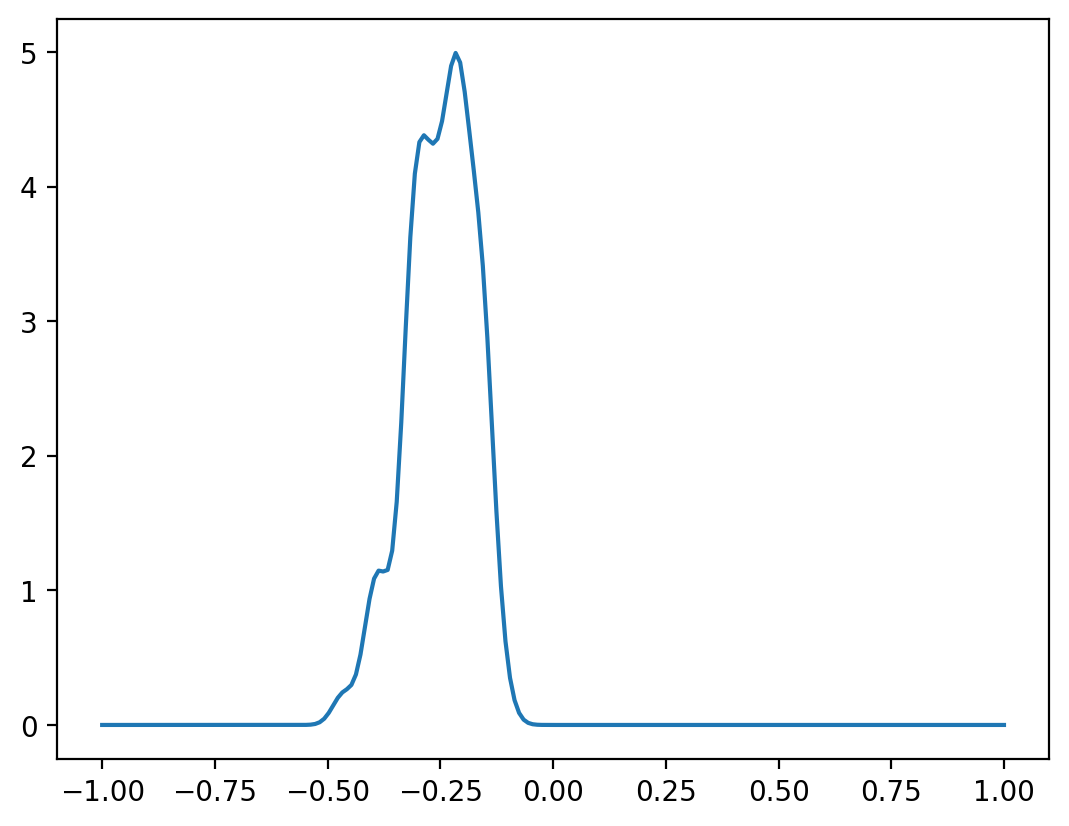

In [172]:
xx = np.linspace(-1,1,200)
plt.plot(xx, [ypred_kde.pdf(x) for x in xx])

In [198]:
putative_x = knot_x[3]

# we need to average over many samples of tights to get the final answer
%time ess_and_estimate_entropy(putative_x, tight, knot_y, knot_cK, rng_key, J=50)

CPU times: user 1.77 s, sys: 24 ms, total: 1.8 s
Wall time: 1.77 s


1.2358570685592536

# Redoing the IG computation

In [47]:
### TODO: use the right mean and covariance

# Number of samples from the posterior
num_pred = 500

npr.seed(5)
# Form the true function of interest at knot_N number of points
true_y = knot_cK.T @ npr.randn(knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0], knot_x[-1]])
train_y = np.array([true_y[0], true_y[-1]])

pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

pred_cK = spla.cholesky(pred_cov)
pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]

envelopes = convelope(knot_x, pred_Y.T)
tights = np.abs(envelopes - pred_Y.T) < 1e-3

# Compute entropy change
#entropy_change = compute_mean_entropy(knot_x, pred_Y, pred_mean, pred_cov)
#best_idx = np.argmax(entropy_change)
#print(best_idx)

#plot_results(knot_x, true_y, true_envelope, envelopes, entropy_change, knot_N, best_idx)

Text(0.5, 1.0, 'Envelope samples')

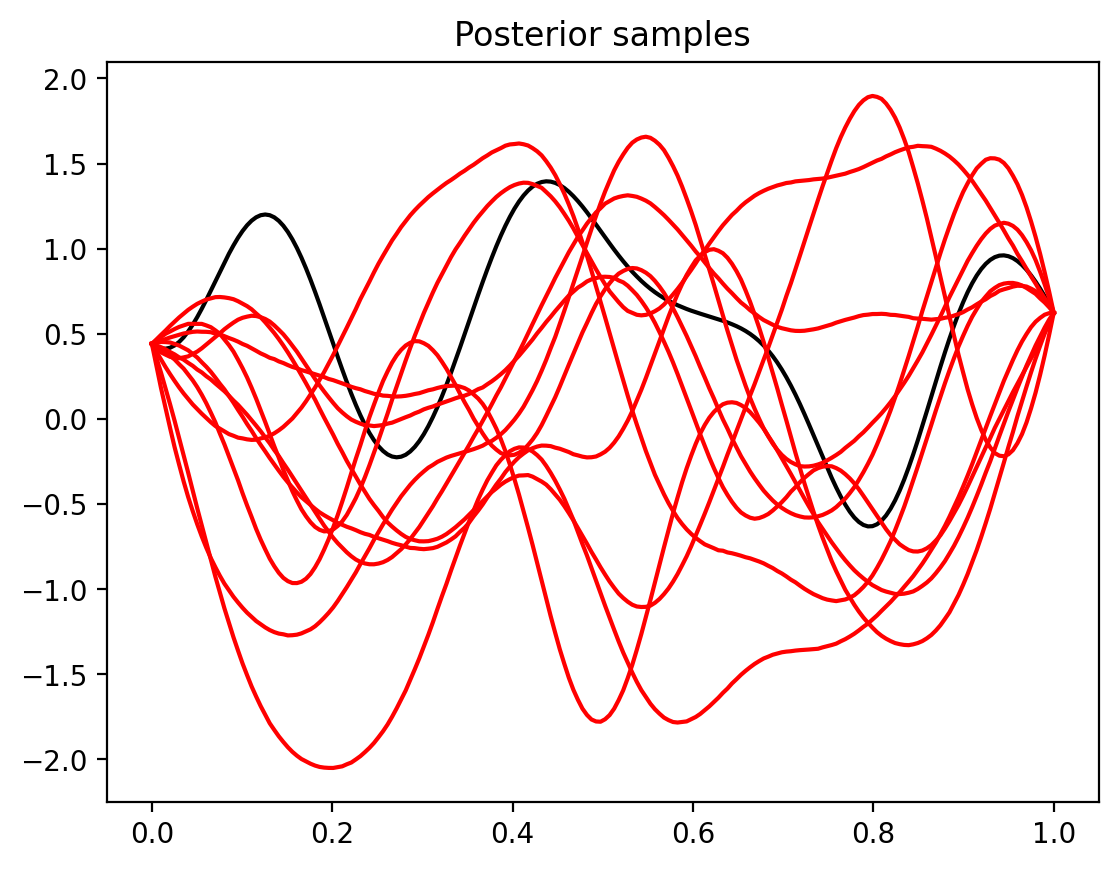

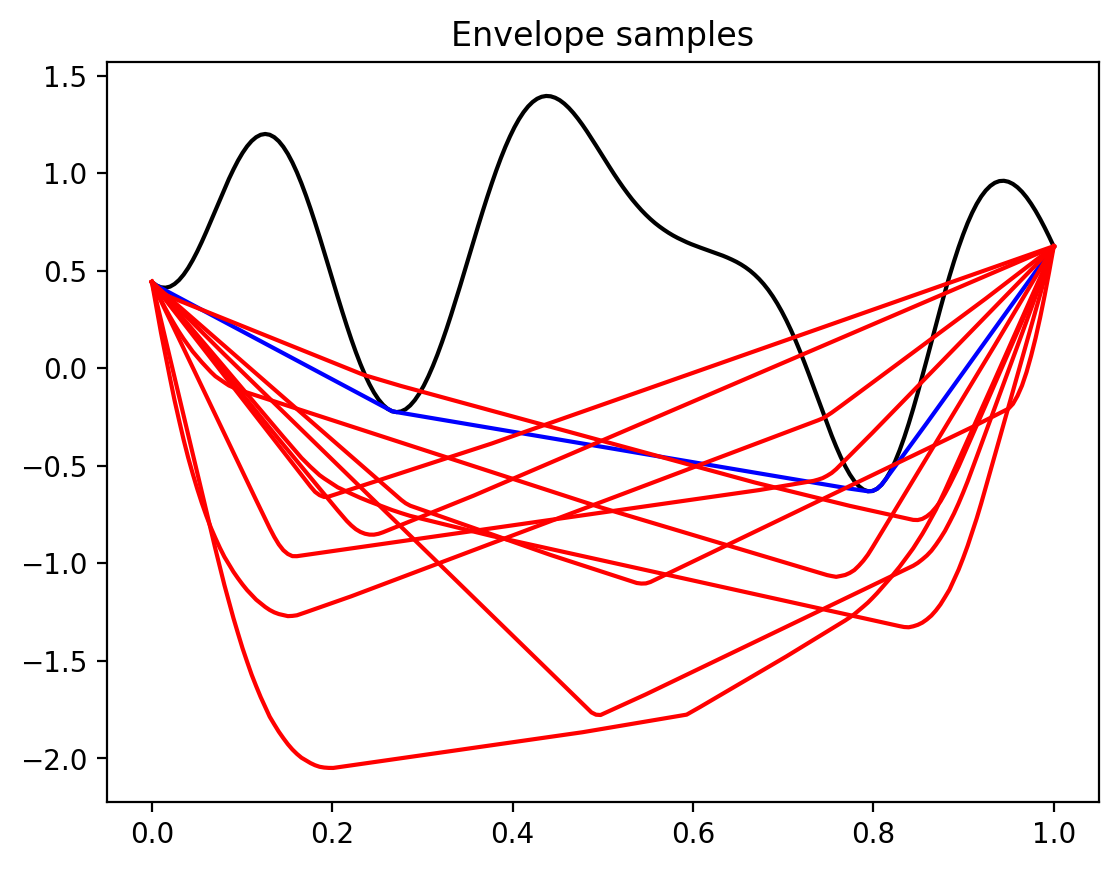

In [48]:
plt.figure()
plt.plot(knot_x,  true_y, 'k-', knot_x, pred_Y[:,:10], 'r-')
#plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=2)
plt.title('Posterior samples')

plt.figure()
plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, envelopes[:10,:].T, 'r-')
#plt.axvline(knot_x[best_idx], ls="dotted", c="k", lw=3)
plt.title('Envelope samples')

In [49]:
sampled_f = pred_Y[:,:1]
sampled_h = envelopes[:1,:].T

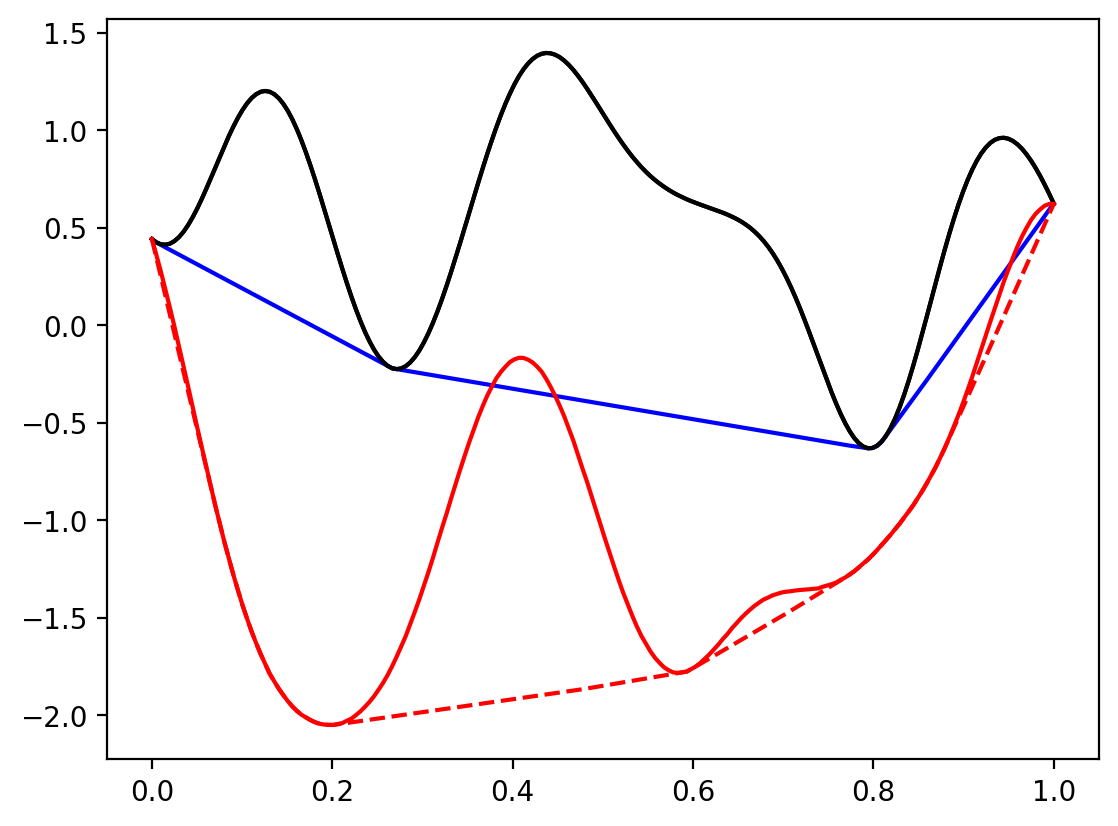

In [50]:
plt.plot(knot_x,  true_y, 'k-', knot_x, true_envelope.T, 'b-', knot_x, sampled_h, 'r--')
plt.plot(knot_x,  true_y, 'k-', knot_x, sampled_f, 'r-')

In [51]:
rng_key = jrnd.PRNGKey(1)

samps = elliptical_slice_jax(knot_y, lambda x: np.log(same_tight(x, tight)), knot_cK, 500, rng_key)

In [61]:
knot_y.shape

(200,)

In [63]:
sampled_f.ravel().shape

(200,)

In [104]:
llh = lambda x: np.log(same_tight(x, tights[:1]))
llh(sampled_f.ravel())

DeviceArray(0., dtype=float32)

In [69]:
samps = elliptical_slice(sampled_f.ravel(), lambda x: np.log(same_tight(x, tights[:1])), pred_cK, 300)

100%|██████████| 300/300 [00:03<00:00, 79.19it/s]


In [56]:
len(knot_y)

200

In [54]:
(sampled_f - pred_mean).mean()

DeviceArray(-1.16440472, dtype=float64)

In [47]:
pred_cK

DeviceArray([[1.41421321e-03, 7.06214026e-04, 7.03544100e-04, ...,
              2.35022439e-25, 8.89280876e-26, 1.36383334e-31],
             [0.00000000e+00, 5.02344691e-02, 1.00166007e-01, ...,
              4.22741484e-21, 1.60602711e-21, 2.50352362e-27],
             [0.00000000e+00, 0.00000000e+00, 4.26378145e-03, ...,
              3.16609731e-20, 1.20767733e-20, 1.91388278e-26],
             ...,
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
              1.15835158e-03, 3.09312114e-04, 2.84987840e-04],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
              0.00000000e+00, 1.17195833e-03, 4.23928322e-04],
             [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
              0.00000000e+00, 0.00000000e+00, 1.29495722e-03]],            dtype=float64)

In [34]:
putative_x = 0.8

#s = tights[1]

mean_entropy = 0
N_entropy_samps = 10

#for i in N_entropy_sampls


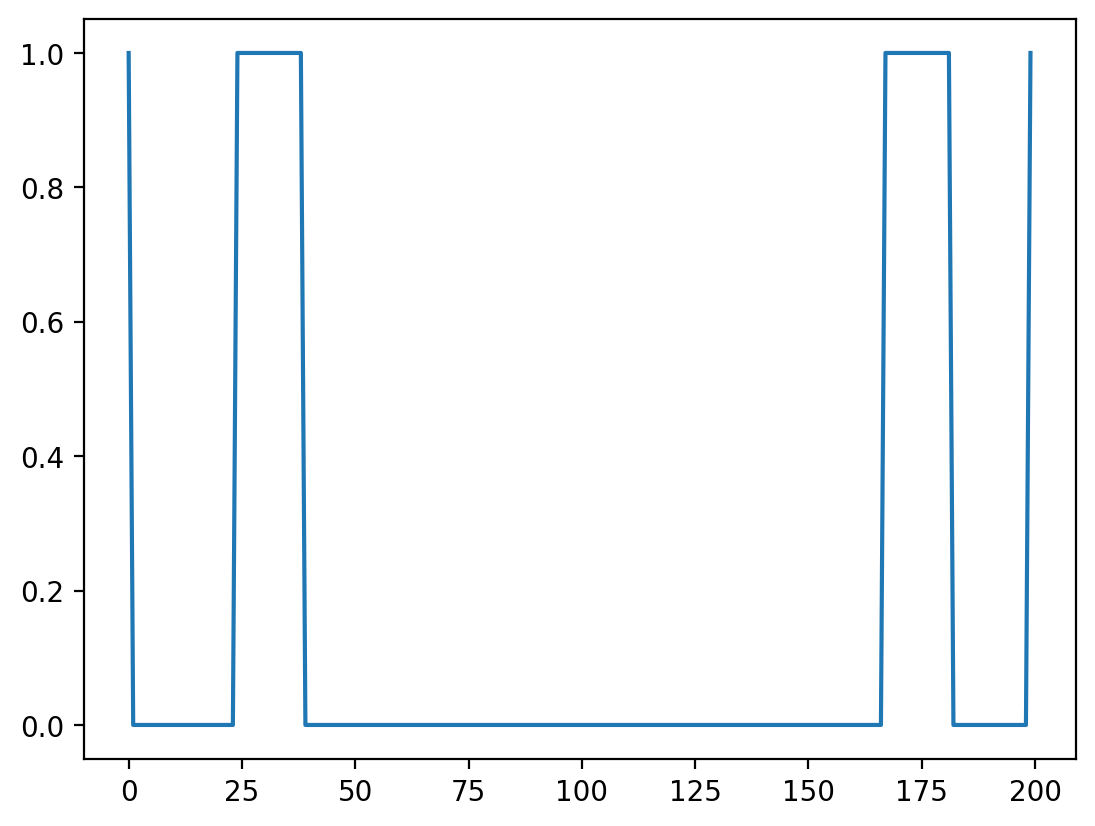

In [43]:
plt.plot(tight)

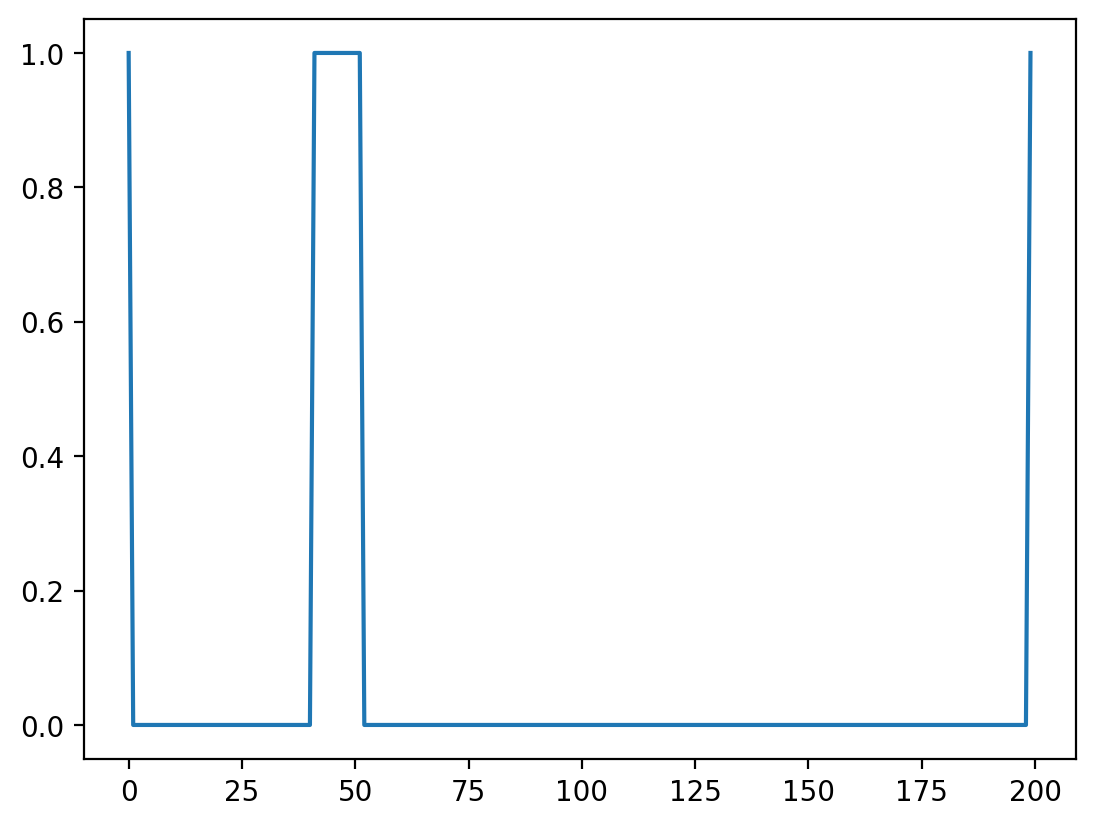

In [42]:
plt.plot(tights[3])

In [44]:
tights.shape

(500, 200)

In [98]:
# 
entropy_est = 0
N_est = 10
for i in range(N_est):
    entropy_est += ess_and_estimate_entropy(knot_x[1], tights[i], pred_Y[:,i], pred_cK, J=200)                              

In [100]:
entropy_est / N_est

3.75024407723039

In [88]:
def compute_IG_putative_x(putative_x, data, rng_key, T=100, J=200):
    """
    Compute a Monte Carlo approximation of the IG w.r.t. T samples of s_t ~ p(s | data).
    
    The inner entropy is approximated via Monte Carlo + a KDE estimator constructed from the samples. 
    (TODO: don't use the same data twice)
    
    T: number of samples for the outer expectation
    J: number of ESS samples (controls the # of samples for the inner MC too?)
    
    data: TODO figure out how to represent this best
    """
    
    entropies = np.zeros(T)
    
    train_x, train_y = data
    
    # sample functions ~ posterior
    pred_mean, pred_cov = make_preds(train_x, train_y, knot_x) # what is knot_x? (right now it's a global variable)
    
    ## TODO: is this the correct thing to use?
    pred_cK = spla.cholesky(pred_cov)
    # get T samples from the posterior
    pred_Y = pred_cK.T @ npr.randn(knot_N, T) + pred_mean[:,np.newaxis]

    # get s by computing the vector of tights w.r.t. posterior samples
    envelopes = convelope(knot_x, pred_Y.T)
    tights = np.abs(envelopes - pred_Y.T) < 1e-3

    mean_entropy = 0
    
    for t in tqdm.tqdm(range(T)):
        
        s = tights[t]
        entropy_term = ess_and_estimate_entropy(putative_x, s, pred_Y[:,t], pred_cK, rng_key, J=J)
        mean_entropy += entropy_term
        # get the estimates of 
        #entropies = entropies.at[t].set( ess_and_estimate_entropy(putative_x, s, pred_Y[:,t], pred_cK, J=J)   )        
    
    return mean_entropy / T
    #return entropies
    
    
def get_next_candidate(data, designs, rng_key, T=30, J=40):
    """
    Given current data and a list of designs, computes a score for each design. 
    Returns the best design and the list of scores. 
    """
    scores = np.zeros(len(designs))
    for i, x in enumerate(designs):
        scores = scores.at[i].set( compute_IG_putative_x(x, data, rng_key, T = T, J = J) )
    
    return scores.argmax(), scores

In [89]:
rng_key = jrnd.PRNGKey(1)
entropies = compute_IG_putative_x(knot_x[1], (train_x, train_y), rng_key, T = 30, J=40)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:58<00:00,  1.96s/it]


In [90]:
entropies

4.436934233640723

In [70]:
np.linspace(0,1,5)

DeviceArray([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float64)

In [77]:
next_x, scores = get_next_candidate((train_x, train_y), np.linspace(0,1,5))


# suggest next candidate

# add best candidate to data set
    

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [01:11<00:00,  2.38s/it]


In [82]:
scores

DeviceArray([4.53660262, 1.71113546, 1.43342395, 1.17503269, 4.25215886],            dtype=float64)

In [83]:
np.linspace(0,1,5)

DeviceArray([0.  , 0.25, 0.5 , 0.75, 1.  ], dtype=float64)

In [74]:
def compute_mean_entropy_IG(knot_x, pred_Y, pred_mean, pred_cov):
    
    N_est = 10
    
    entropies = []
    
    # loop over putative x's
    for nn in tqdm.tqdm(range(knot_N)):
        
        putative_x = knot_x
    
        mean_entropy = 0

        # Loop over outer samples from the posterior [need to specify number and then divide by it]
        num_post_samps = 100
        for i in range(num_post_samps):

            # Sample a function f from the posterior

            # Compute those functions' hull h

            # Compute the vector s that tells us whether or not each training point of the sampled f is tight

            
            # estimate the entropy for a fixed s TODO: ADD XX (y0's) and YY (cov)
            mean_entropy += ess_and_estimate_entropy(putative_x, tight, XX, YY, J=num_post_samps)
        
        mean_entropy = mean_entropy / N_est
        
        entropies.append(mean_entropy)
        
    return entropies
        
    """
    
    num_y_bins = 10
    
    u_borders = np.linspace(0, 1, num_y_bins+1)

    envelopes = convelope(knot_x, pred_Y.T)
    tights = np.abs(envelopes - pred_Y.T) < 1e-3
    p_tight = np.clip(np.mean(tights, axis=0), 1e-6, 1-1e-6)
    
    cur_entropy = -np.sum( p_tight*np.log2(p_tight) + (1-p_tight)*np.log2(1-p_tight))

    # Do this with slow loops to start out. ### TODO: modify this to compute IG with posterior
    entropy_change = []
    for nn in tqdm.tqdm(range(knot_N)):
        mean = pred_mean[nn]
        var  = pred_cov[nn,nn]
        borders = sps.norm.ppf(u_borders, loc=mean, scale=np.sqrt(var))[:,np.newaxis]
        Y = pred_Y[nn,:]
        Ybin = np.logical_and(borders[:-1] <= Y, Y < borders[1:]).T

        mean_entropy = 0
        for ii in range(num_y_bins):
            cond_p_tight = np.clip(np.mean(tights[Ybin[:,ii],:], axis=0), 1e-6, 1-1e-6)
            cond_entropy = -np.sum( cond_p_tight*np.log2(cond_p_tight) + (1-cond_p_tight)*np.log2(1-cond_p_tight))
            mean_entropy += cond_entropy/num_y_bins
        entropy_change.append(cur_entropy - mean_entropy)
    entropy_change = np.array(entropy_change)
    return entropy_change
    """

In [ ]:
num_pred = 500

npr.seed(5)
# Form the true function of interest at knot_N number of points
true_y = knot_cK.T @ npr.randn(knot_N)

# Let's imagine that we start out by observing the two end points.
train_x = np.array([knot_x[0], knot_x[-1]])
train_y = np.array([true_y[0], true_y[-1]])

pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

pred_cK = spla.cholesky(pred_cov)
pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]

# Compute entropy change
entropy_change = compute_mean_entropy(knot_x, pred_Y, pred_mean, pred_cov)
best_idx = np.argmax(entropy_change)
print(best_idx)

plot_results(knot_x, true_y, true_envelope, envelopes, entropy_change, knot_N, best_idx)

for i in range(3):
    print("Observing: ", best_idx)

    # Make prediction at the best_idx point
    train_x = np.append(train_x, knot_x[best_idx])
    train_y = np.append(train_y, true_y[best_idx])

    pred_mean, pred_cov = make_preds(train_x, train_y, knot_x)

    pred_cK = spla.cholesky(pred_cov)
    pred_Y = pred_cK.T @ npr.randn(knot_N, num_pred) + pred_mean[:,np.newaxis]
    
    # Compute entropy change
    entropy_change = compute_mean_entropy_IG(knot_x, pred_Y, pred_mean, pred_cov)
    best_idx = np.argmax(entropy_change)
    print(best_idx)
    
    envelopes = convelope(knot_x, pred_Y.T)
    #tights = np.abs(envelopes - pred_Y.T) < 1e-3
    #p_tight = np.clip(np.mean(tights, axis=0), 1e-6, 1-1e-6)
    
    # Plot results
    plot_results(knot_x, true_y, true_envelope, envelopes, entropy_change, knot_N, best_idx)